A Univariate Time Series Model that relates Sales and Orders

In [21]:
#Pandas, numpy for data handling
import pandas as pd
import numpy as np
import sys
import itertools
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
#Matlplotlib for plotting
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt

Reading Dataset into a Pandas DataFrame

In [22]:
df=pd.read_csv('Dataset/DataCoSupplyChainDataset.csv',encoding='unicode_escape')

Data Cleaning 
1. Drop all columns except Orders and Sales
2. Take care of NULL/Missing Values in these columns

In [45]:
#data=df.drop(columns=['Order Zipcode', 'Product Description','Customer Email','Customer Password','Customer Street','Latitude','Longitude','Order Id','Order Item Cardprod Id','Order Zipcode','Product Description','Product Image'])
data=df.rename(columns = {'order date (DateOrders)': 'Order_Date'}, inplace = False)
data = data[['Order_Date','Sales','Department Id','Department Name']]
data = data.dropna()
data.head()

,Order_Date,Sales,Department Id,Department Name
0,1/31/2018 22:56,327.75,2,Fitness
1,1/13/2018 12:27,327.75,2,Fitness
2,1/13/2018 12:06,327.75,2,Fitness
3,1/13/2018 11:45,327.75,2,Fitness
4,1/13/2018 11:24,327.75,2,Fitness


Normalising the Numerical values, i.e, sales

In [46]:
sales=data['Sales']
values = sales.values
values = values.reshape((len(values),1))
scaler = StandardScaler()
scaler = scaler.fit(values)
normalized = scaler.transform(values)
sales=pd.DataFrame(data=normalized,index=range(0,len(values)),columns=['Sales'])
data.drop(labels=['Sales'], axis="columns", inplace=True)
data['Sales'] = sales['Sales']
data.isnull().sum()
#data = data.dropna()
data.head()

,Order_Date,Department Id,Department Name,Sales
0,1/31/2018 22:56,2,Fitness,0.93729
1,1/13/2018 12:27,2,Fitness,0.93729
2,1/13/2018 12:06,2,Fitness,0.93729
3,1/13/2018 11:45,2,Fitness,0.93729
4,1/13/2018 11:24,2,Fitness,0.93729


Null Values

In [47]:
data.isnull().sum()

Order_Date         0
Department Id      0
Department Name    0
Sales              0
dtype: int64

Check the range of Data with respect to order dates

In [48]:
data['Order_Date'].min(), data['Order_Date'].max()

('1/1/2015 0:00', '9/9/2017 9:50')

In [49]:
#everyday=data1.loc[data['Department Id'] == 7]
everyday=data[['Order_Date','Sales']]
everyday['Date'] = [x.split(None, 1)[0] for x in everyday['Order_Date']]
everyday['Year'] = [x.split('/')[2][:4] for x in everyday['Order_Date']]
everyday.head()
everyday['Year'].groupby(everyday.Year).agg('count')

Year
2015    62650
2016    62550
2017    53196
2018     2123
Name: Year, dtype: int64

In [50]:
#everyday=everyday.groupby('Order_Date')['Sales'].sum().reset_index()
everyday=everyday.groupby('Date')['Sales'].sum().reset_index()

In [51]:
#everyday=everyday.set_index('Order_Date')
everyday=everyday.set_index('Date')

In [52]:
everyday.head()

,Sales
Date,
1/1/2015,-10.793016
1/1/2016,-28.291783
1/1/2017,5.587585
1/1/2018,149.551169
1/10/2015,1.293626


In [53]:
everyday.index = pd.to_datetime(everyday.index)
y = everyday['Sales'].resample('MS').mean()
y.head()

Date
2015-01-01    -8.019847
2015-02-01    -9.889834
2015-03-01   -10.089685
2015-04-01    -7.578405
2015-05-01   -10.030274
Freq: MS, Name: Sales, dtype: float64

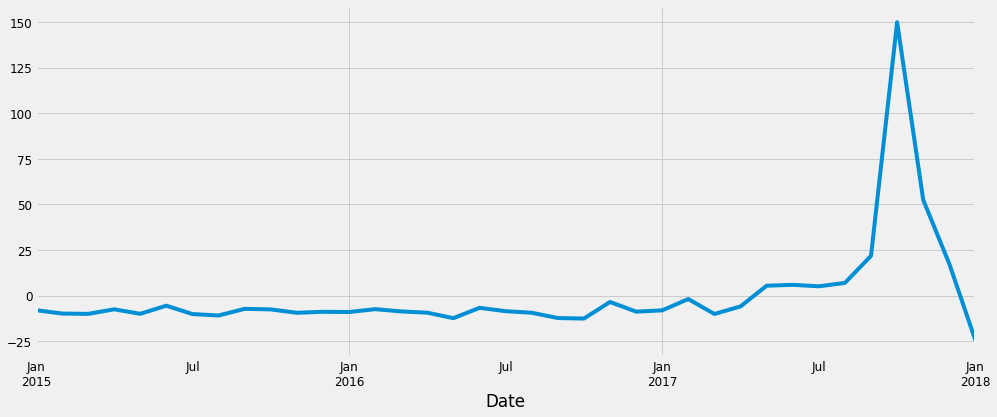

In [54]:
y.plot(figsize=(15, 6))
plt.show()

Time-series Decomposition

Seperating the cyclic/seasonal and residual/noise components from the trend, to observe the effect that they have on overall sales.

Trend: The increasing or decreasing value in the series.

Seasonality: The repeating short-term cycle in the series.

Residual: The random variation in the series


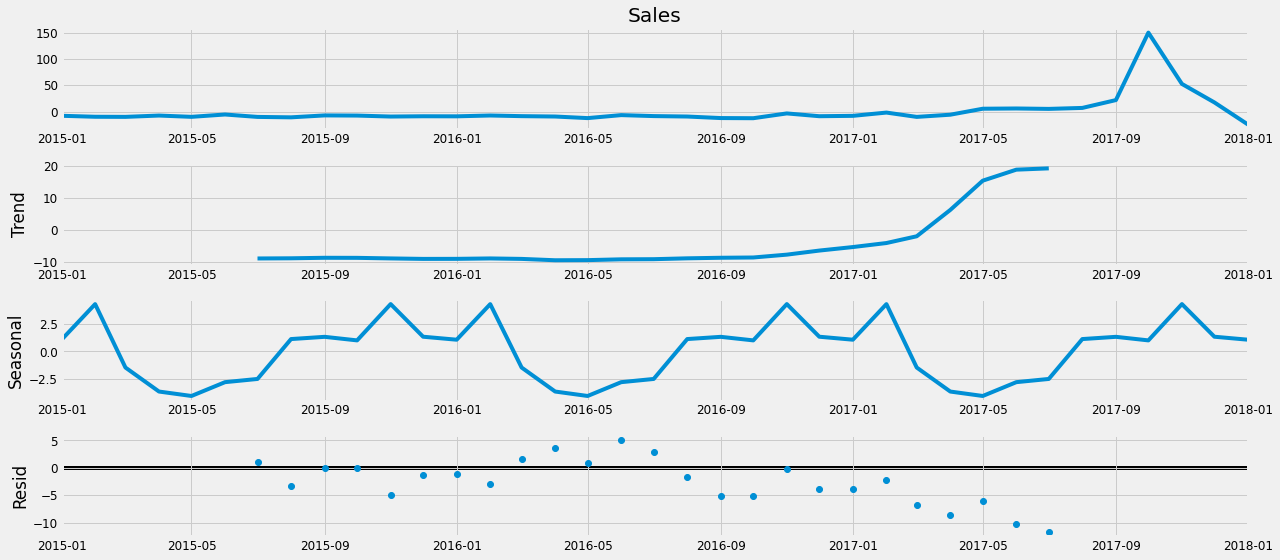

In [55]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')#multiplicative
fig = decomposition.plot()
plt.show()


MODEL1: SARIMA(Seasonal Autoregressive Integrated Moving Average)

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series:

    p: Trend autoregression order
    d: Trend difference order
    q: Trend moving average order



Generating all possible combinations of p,d,q to find which suits our data the best - comparison done using AIC
(Akaike Information Critera) : a widely used measure of a statistical model that quantifies 

1) the goodness of fit
2) the simplicity/parsimony

When comparing two models, the one with the lower AIC is generally “better”



In [56]:
 p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [57]:
minimal_AIC=sys.float_info.max
l=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            if(results.aic<minimal_AIC):
                l=[]
                l.append(param)
                l.append(param_seasonal)
                l.append(results.aic)
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
print(l)

[(1, 1, 1), (1, 1, 1, 12), 115.98914604922305]


[(1, 1, 1),(1, 1, 1, 12), 115.71130796243541] - gives the lowest AIC Value

In [58]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1),seasonal_order=(1, 1, 1, 12),enforce_stationarity=False,enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4016      1.702      0.236      0.813      -2.934       3.737
ma.L1         -1.0001   2709.360     -0.000      1.000   -5311.249    5309.249
ar.S.L12      -0.0002     17.592  -1.28e-05      1.000     -34.479      34.479
ma.S.L12      -1.0156    987.904     -0.001      0.999   -1937.272    1935.241
sigma2      1396.5950   4.04e+06      0.000      1.000   -7.92e+06    7.92e+06


In [59]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

In [60]:
y.head()


Date
2015-01-01    -8.019847
2015-02-01    -9.889834
2015-03-01   -10.089685
2015-04-01    -7.578405
2015-05-01   -10.030274
Freq: MS, Name: Sales, dtype: float64

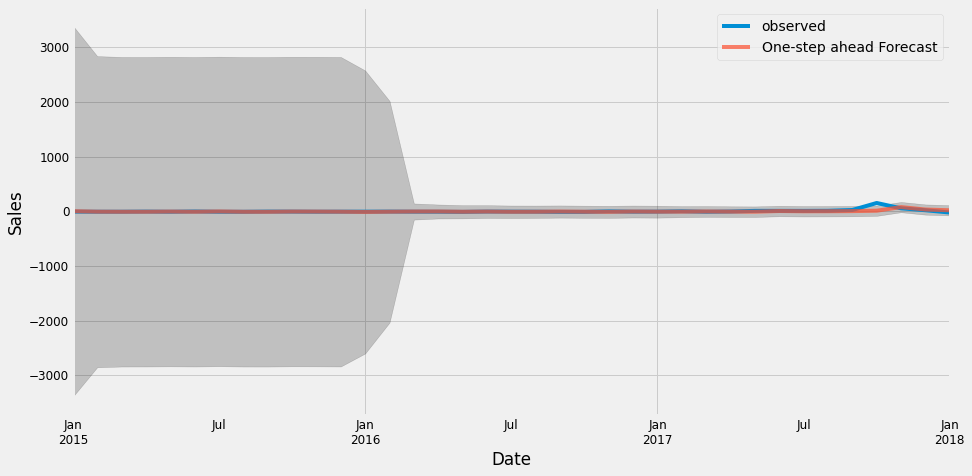

In [61]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [62]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
print(type(y_forecasted))
print(y_truth)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
"""the smaller the MSE, the closer we are to finding the line of best fit."""

<class 'pandas.core.series.Series'>
Date
2017-01-01     -8.140807
2017-02-01     -1.936207
2017-03-01    -10.136589
2017-04-01     -5.982223
2017-05-01      5.372353
2017-06-01      5.849239
2017-07-01      5.051478
2017-08-01      6.908065
2017-09-01     21.773627
2017-10-01    149.858549
2017-11-01     52.457967
2017-12-01     17.339271
2018-01-01    -24.621187
Freq: MS, Name: Sales, dtype: float64
The Mean Squared Error of our forecasts is 1777.47


'the smaller the MSE, the closer we are to finding the line of best fit.'

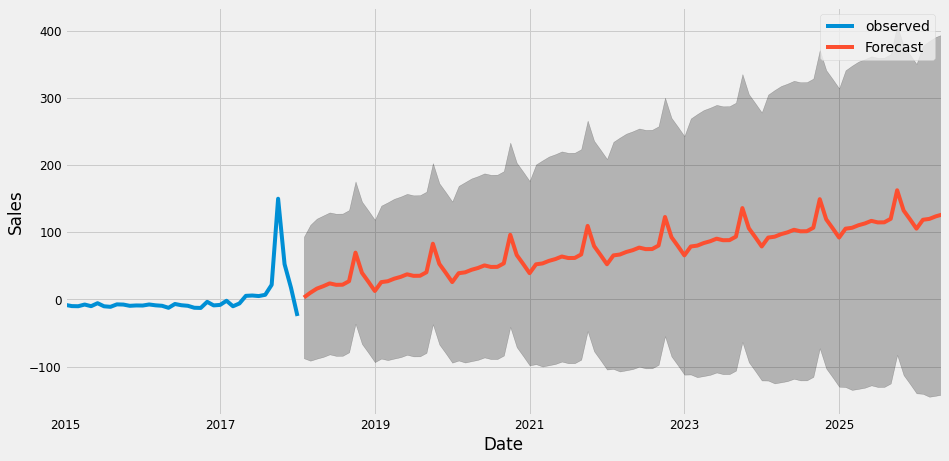

In [63]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()#gives confidence interval
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [43]:
# """using prophet"""
# from fbprophet import Prophet
# # pro = data.rename([]'Order_Date': 'ds', 'Sales': 'y')
# pro = data[['Order_Date','Sales']]
# pro = pro.rename(columns={'Order_Date': 'ds', 'Sales': 'y'})
# pro.head()
# pro_model = Prophet(interval_width=0.95)
# pro_model.fit(pro)
# #office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
# #office_model = Prophet(interval_width=0.95)
# #office_model.fit(office)
# pro_forecast = pro_model.make_future_dataframe(periods=36, freq='MS')
# pro_forecast = pro_model.predict(pro_forecast)
# #office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
# #office_forecast = office_model.predict(office_forecast)
# plt.figure(figsize=(18, 6))
# pro_model.plot(pro_forecast, xlabel = 'Date', ylabel = 'Sales')
# plt.title('Total Sales');